In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy
import math
from datetime import datetime
import matplotlib.animation as animation
from PIL import Image
import random
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
epsilon = math.ulp(1.0)

def softmax(x):
    return np.nan_to_num((np.exp(x)+epsilon))/np.nan_to_num((sum(np.exp(x))+epsilon))

def simulate_allstarts(eta,simlen,beta,a,h,noise,H):
    m_log=np.zeros([simlen,P,P])
    x_log=np.zeros([simlen,P,N])
    x_last=np.zeros([N,P])
    projection=((a*xi)+(h*(xi@H))).T # auto+hetero
    for start_node in range(P):
        x=xi[:,start_node]+noise*(np.random.rand(N)-0.5)
        for t in range(simlen):
            r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
            r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
            x+=eta*(r[0]-x)
            m=np.zeros(P)
            for i in range(P):
                m[i] = np.corrcoef(x,xi[:,i])[0,1]
            x_log[t,start_node,:]=x
            m_log[t,start_node,:]=m
        x_last[:,start_node]=x
    autocorr = np.corrcoef(x_last.T) #correlation between attractors

    return (autocorr, m_log, x_log)

def simulate_allstarts_freq(eta,simlen,beta,a,h,freq,noise,H):
    m_log=np.zeros([simlen,P,P])
    x_last=np.zeros([N,P])
    projection=((a*xi)+(h*(xi@H))).T # auto+hetero
    for start_node in range(P):
        x=xi[:,start_node]+noise*(np.random.rand(N)-0.5)
        stim_node=start_node-freq
        for t in range(simlen):
            if (t>1) & (t%freq==0):
                x+=xi[:,stim_node%P]+0.0
                stim_node-=freq
            r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
            x+=eta*(r[0]-x)
            m=np.zeros(P)
            for i in range(P):
                m[i] = np.corrcoef(x,xi[:,i])[0,1]
            m_log[t,:,:]=m
        x_last[:,start_node]=x
    cor_activity=np.corrcoef(x_last.T) #correlation between attractors
    return (m_log, cor_activity)

def get_h(a):
    return 1-a

def get_a(h):
    return h-1

def corr_steps(x_log, xi, steps):
    corrs1 = corr_step(x_log, xi, steps[0])
    corrs2 = corr_step(x_log, xi, steps[1])
    corrs3 = corr_step(x_log, xi, steps[2])
    corrs4 = corr_step(x_log, xi, steps[3])
    return (corrs1, corrs2, corrs3, corrs4)

def corr_step(x_log, xi, step):
    corrs = np.zeros((P,P))
    for x_last in range(0,P):
        for pattern in range(0,P):
            corrs[x_last,pattern] = np.corrcoef(x_log[step,x_last,:],xi[:,pattern])[0][1]
    return corrs

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [3]:
for dirname, _, filenames in os.walk('fashionmnist'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

fashionmnist\fashion-mnist_test.csv
fashionmnist\fashion-mnist_train.csv
fashionmnist\t10k-images-idx3-ubyte
fashionmnist\t10k-labels-idx1-ubyte
fashionmnist\train-images-idx3-ubyte
fashionmnist\train-labels-idx1-ubyte


In [4]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# fashion-mnist_test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('fashionmnist/fashion-mnist_test.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'fashion-mnist_test.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 785 columns


In [5]:
df1.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
for P in [10, 20, 30]:
    N = 784
    G_fmnist = nx.empty_graph(P) # memory graph
    H = nx.adjacency_matrix(G_fmnist) # adjacency matrix
    pos_fmnist = nx.circular_layout(G_fmnist, scale=1)

    #memories
    fmnist_pixel_data = df1.iloc[0:P].to_numpy().T[1:,:]
    xi = fmnist_pixel_data/np.max(fmnist_pixel_data)
    xi_mean=np.sum(xi, axis=1, keepdims=True)/P
    xi_bias=xi-xi_mean

    simlen = 100
    beta = 1
    eta = 0.1
    noise = 1

    a1=1
    h1=0
    autocorr1, m_log1, x_log1 = simulate_allstarts(eta,simlen,beta,a1,h1,noise,H)
    
    corrs = corr_step(x_log1, xi, simlen-1)
    predictions = np.equal(corrs.max(axis=0),np.diagonal(corrs))
    correct_fraction = np.sum(predictions)/P
    
    print(P,correct_fraction)

10 0.8
20 0.8
30 0.6666666666666666


In [7]:
for P in [10, 20, 30]:
    N = 784
    G_fmnist = nx.empty_graph(P) # memory graph
    H = nx.adjacency_matrix(G_fmnist) # adjacency matrix
    pos_fmnist = nx.circular_layout(G_fmnist, scale=1)

    #memories
    fmnist_pixel_data = df1.iloc[0:P].to_numpy().T[1:,:]
    xi = fmnist_pixel_data/np.max(fmnist_pixel_data)
    xi_mean=np.sum(xi, axis=1, keepdims=True)/P
    xi_bias=xi-xi_mean

    simlen = 100
    beta = 1
    eta = 0.1
    noise = 1

    a1=0.5
    h1=0.5
    autocorr1, m_log1, x_log1 = simulate_allstarts(eta,simlen,beta,a1,h1,noise,H)
    
    corrs = corr_step(x_log1, xi, simlen-1)
    predictions = np.equal(corrs.max(axis=0),np.diagonal(corrs))
    correct_fraction = np.sum(predictions)/P
    
    print(P,correct_fraction)

10 0.5
20 0.15
30 0.1


In [8]:
for P in [10, 20, 30]:
    N = 784
    G_fmnist = nx.empty_graph(P) # memory graph
    H = nx.adjacency_matrix(G_fmnist) # adjacency matrix
    pos_fmnist = nx.circular_layout(G_fmnist, scale=1)

    #memories
    fmnist_pixel_data = df1.iloc[0:P].to_numpy().T[1:,:]
    xi = fmnist_pixel_data/np.max(fmnist_pixel_data)
    xi_mean=np.sum(xi, axis=1, keepdims=True)/P
    xi_bias=xi-xi_mean

    simlen = 100
    beta = 1
    eta = 0.1
    noise = 1

    a1=0.1
    h1=0.9
    autocorr1, m_log1, x_log1 = simulate_allstarts(eta,simlen,beta,a1,h1,noise,H)
    
    corrs = corr_step(x_log1, xi, simlen-1)
    predictions = np.equal(corrs.max(axis=0),np.diagonal(corrs))
    correct_fraction = np.sum(predictions)/P
    
    print(P,correct_fraction)

10 1.0
20 1.0
30 1.0


In [9]:
for P in [10, 20, 30]:
    N = 784
    G_fmnist = nx.empty_graph(P) # memory graph
    H = nx.adjacency_matrix(G_fmnist) # adjacency matrix
    pos_fmnist = nx.circular_layout(G_fmnist, scale=1)

    #memories
    fmnist_pixel_data = df1.iloc[0:P].to_numpy().T[1:,:]
    xi = fmnist_pixel_data/np.max(fmnist_pixel_data)
    xi_mean=np.sum(xi, axis=1, keepdims=True)/P
    xi_bias=xi-xi_mean

    simlen = 100
    beta = 1
    eta = 0.1
    noise = 1

    a1=0.9
    h1=0.1
    autocorr1, m_log1, x_log1 = simulate_allstarts(eta,simlen,beta,a1,h1,noise,H)
    
    corrs = corr_step(x_log1, xi, simlen-1)
    predictions = np.equal(corrs.max(axis=0),np.diagonal(corrs))
    correct_fraction = np.sum(predictions)/P
    
    print(P,correct_fraction)

10 0.9
20 0.75
30 0.7666666666666667


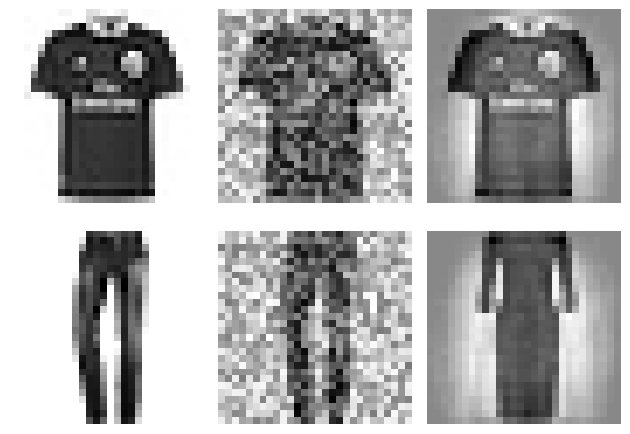

In [10]:
f, axarr = plt.subplots(2,3)

items = [0,1]

axarr[0,0].imshow(xi[:,items[0]].reshape((28,28)), interpolation='nearest', cmap='binary')
axarr[0,1].imshow(x_log1[0,items[0],:].reshape((28,28)), interpolation='nearest', cmap='binary')
axarr[0,2].imshow(x_log1[-1,items[0],:].reshape((28,28)), interpolation='nearest', cmap='binary')

axarr[1,0].imshow(xi[:,items[1]].reshape((28,28)), interpolation='nearest', cmap='binary')
axarr[1,1].imshow(x_log1[0,items[1],:].reshape((28,28)), interpolation='nearest', cmap='binary')
axarr[1,2].imshow(x_log1[-1,items[1],:].reshape((28,28)), interpolation='nearest', cmap='binary')

axarr[0,0].axis('off')
axarr[0,1].axis('off')
axarr[0,2].axis('off')
axarr[1,0].axis('off')
axarr[1,1].axis('off')
axarr[1,2].axis('off')

plt.tight_layout()
# plt.savefig("fmnist_examples.pdf", format="pdf", bbox_inches="tight")
plt.show()